In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np

import matplotlib.pyplot as plt


In [76]:
df=pd.read_csv("Stock_Price_Train.csv",index_col=0,parse_dates=True)
df.head(12)

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"
2012-01-10,313.70,315.72,307.30,621.43,"8,824,000"
2012-01-11,310.59,313.52,309.40,624.25,"4,817,800"
2012-01-12,314.43,315.26,312.08,627.92,"3,764,400"
2012-01-13,311.96,312.30,309.37,623.28,"4,631,800"


<AxesSubplot:xlabel='Date'>

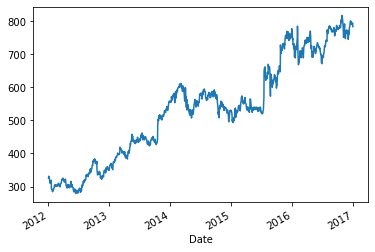

In [77]:
df["Open"].plot()

In [78]:
train=df.Open.values

In [79]:
train=train
train

array([325.25, 331.27, 329.83, ..., 793.7 , 783.33, 782.75])

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1))
train=scaler.fit_transform(train.reshape(-1,1))


In [81]:
train=torch.FloatTensor(train).view(-1)

In [82]:
train

tensor([-0.8284, -0.8060, -0.8113,  ...,  0.9145,  0.8759,  0.8738])

In [83]:
test_size=30
def input_data(seq,ws):
    out=[]
    L=len(seq)
    
    for i in range(L-ws):
        window=seq[i:i+ws]
        label=seq[i+ws:i+ws+1]
        
        out.append((window,label))
        
    return out
        

In [84]:
train_data=input_data(train,test_size)

In [85]:
train_data[0]

(tensor([-0.8284, -0.8060, -0.8113, -0.8169, -0.8403, -0.8713, -0.8829, -0.8686,
         -0.8778, -0.8672, -0.8771, -0.8505, -0.9440, -0.9524, -0.9518, -0.9682,
         -0.9784, -0.9807, -0.9671, -0.9580, -0.9544, -0.9545, -0.9438, -0.9357,
         -0.9132, -0.9105, -0.9042, -0.9119, -0.9070, -0.9051]),
 tensor([-0.9025]))

In [86]:
len(train_data) #1246+30+30


1228

In [89]:
class RNN(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        
        self.hidden_size=hidden_size
        
        self.rnn1=nn.LSTM(input_size,hidden_size)
        self.linear=nn.Linear(hidden_size,output_size)
        
        self.hidden1=(torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))

        
    def forward(self,x):
        rnn_out1,self.hidden1=self.rnn1(x.view(len(x),1,-1),self.hidden1)
        out=self.linear(rnn_out1.view(len(x),-1))
        return out[-1]

In [90]:
model=RNN()
model


RNN(
  (rnn1): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [91]:
for params in model.parameters():
    print(params.numel())

400
40000
400
400
100
1


In [92]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [93]:
epochs=100
for epoch in range(epochs):
    for seq,y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden1=(torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        pred=model(seq)
        
        loss=criterion(pred,y_train)
        
        loss.backward()
        optimizer.step()
    print("Epoch {} Loss {}".format(epoch,loss.item()))
    

Epoch 0 Loss 0.004137403331696987
Epoch 1 Loss 0.0016359788132831454
Epoch 2 Loss 0.0007789477822370827
Epoch 3 Loss 0.0005381835508160293
Epoch 4 Loss 0.00040234392508864403
Epoch 5 Loss 0.0002986534091178328
Epoch 6 Loss 0.00029199349228292704
Epoch 7 Loss 0.0003078871523030102
Epoch 8 Loss 0.0003306884318590164
Epoch 9 Loss 0.00032542229746468365
Epoch 10 Loss 0.000767442281357944
Epoch 11 Loss 0.0006344758439809084
Epoch 12 Loss 0.0005804684478789568
Epoch 13 Loss 0.000474272936116904
Epoch 14 Loss 0.0006787935853935778
Epoch 15 Loss 0.000536023115273565
Epoch 16 Loss 0.00037528309621848166
Epoch 17 Loss 0.00032584823202341795
Epoch 18 Loss 0.00038068549474701285
Epoch 19 Loss 0.00036733527667820454
Epoch 20 Loss 0.0003720063832588494
Epoch 21 Loss 0.0002696205337997526
Epoch 22 Loss 0.00030099210562184453
Epoch 23 Loss 0.00020880289957858622
Epoch 24 Loss 0.00020884250989183784
Epoch 25 Loss 0.00018739800725597888
Epoch 26 Loss 7.822825136827305e-05
Epoch 27 Loss 0.000116785617137

In [109]:
future=30
preds=train[-test_size:].tolist()
model.eval()
for i in range(future):
    seq=torch.FloatTensor(preds[-test_size:])
    with torch.no_grad():
        model.hidden1=(torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
        out=model(seq)
        preds.append(out.item())
        

In [110]:
preds[test_size:]

[0.8819559812545776,
 0.8822449445724487,
 0.8889760375022888,
 0.8967550992965698,
 0.9010646343231201,
 0.9039564728736877,
 0.9068109393119812,
 0.9087897539138794,
 0.9086814522743225,
 0.9071581959724426,
 0.905497133731842,
 0.9033889174461365,
 0.900833785533905,
 0.8990148305892944,
 0.8978049159049988,
 0.8971154689788818,
 0.8975957036018372,
 0.8985932469367981,
 0.9000282883644104,
 0.901616096496582,
 0.9021552801132202,
 0.9032371044158936,
 0.9040465354919434,
 0.9040808081626892,
 0.9037825465202332,
 0.9037309288978577,
 0.9037091135978699,
 0.9026142954826355,
 0.901526153087616,
 0.9006544947624207]

In [111]:
true_prediction=scaler.inverse_transform(np.array(preds[test_size:]).reshape(-1,1))

In [112]:
true_prediction

array([[784.95212864],
       [785.0297962 ],
       [786.83897936],
       [788.92983559],
       [790.08815241],
       [790.86542078],
       [791.63264427],
       [792.16451006],
       [792.13540074],
       [791.72597991],
       [791.2795196 ],
       [790.71287323],
       [790.02610488],
       [789.53720617],
       [789.2120053 ],
       [789.02669575],
       [789.15577321],
       [789.42389291],
       [789.80960335],
       [790.23637442],
       [790.38129619],
       [790.67206892],
       [790.88962781],
       [790.89883962],
       [790.81867285],
       [790.80479907],
       [790.79893555],
       [790.50467034],
       [790.21219943],
       [789.9779151 ]])

In [113]:
df["Open"][-test_size:]

Date
2016-11-17    766.92
2016-11-18    771.37
2016-11-21    762.61
2016-11-22    772.63
2016-11-23    767.73
2016-11-25    764.26
2016-11-28    760.00
2016-11-29    771.53
2016-11-30    770.07
2016-12-01    757.44
2016-12-02    744.59
2016-12-05    757.71
2016-12-06    764.73
2016-12-07    761.00
2016-12-08    772.48
2016-12-09    780.00
2016-12-12    785.04
2016-12-13    793.90
2016-12-14    797.40
2016-12-15    797.34
2016-12-16    800.40
2016-12-19    790.22
2016-12-20    796.76
2016-12-21    795.84
2016-12-22    792.36
2016-12-23    790.90
2016-12-27    790.68
2016-12-28    793.70
2016-12-29    783.33
2016-12-30    782.75
Name: Open, dtype: float64

In [120]:
x=np.arange("2016-12-30","2017-01-29",dtype="datetime64[D]")

In [121]:
len(x)

30

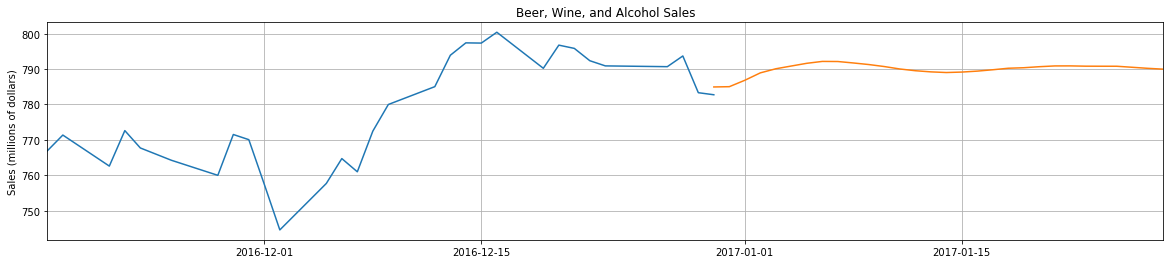

In [124]:
plt.figure(figsize=(20,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Open'][-test_size:])
plt.plot(x,true_prediction)
plt.show()